In [1]:
import os
os.chdir("..")  # 回到项目根目录

In [2]:
pip install pygad

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import chardet

# 自动识别编码的读取函数
def read_csv_auto_encoding(filepath):
    with open(filepath, 'rb') as f:
        result = chardet.detect(f.read())
    return pd.read_csv(filepath, encoding=result['encoding'], index_col=0)

# 1. 读取全部文件
area_df = pd.read_excel('outputs/组团土地类型面积统计_统一英文名.xlsx', index_col=0)
planning_w = read_csv_auto_encoding('outputs/planning_weights.csv').squeeze("columns")  # Series
region_w = read_csv_auto_encoding('outputs/region_weights.csv')
scenario_w = read_csv_auto_encoding('outputs/scenario_weights.csv')
total_area = pd.read_excel('outputs/组团区域总面积统计.xlsx', index_col=0)

# 2. 输出结构确认
files = {
    "Area DF": area_df,
    "Planning Weight": planning_w,
    "Region Weight": region_w,
    "Scenario Weight": scenario_w,
    "Total Area": total_area
}

for name, df in files.items():
    print(f"\n====== {name} ======")
    print("Index:", df.index.tolist())
    print("Columns:", df.columns.tolist() if hasattr(df, 'columns') else "This is a Series")


====== Area DF ======
Index: ['Airport New City', 'Fengdong New City', 'Fengxi New City', 'Jinghe New City', 'Qinhan New City', 'Xixian New Area']
Columns: ['Transportation station land', 'Residential land', 'Sports land', 'Park green land', 'Public facility land', 'Agricultural land', 'Agricultural and forestry land', 'Medical land', 'Historical site protection area', 'Commercial land', 'Basic land', 'Basic green land', 'Industrial land', 'Government land', 'Educational land', 'Cultural land', 'Water area', 'Social welfare land']

====== Planning Weight ======
Index: ['Basic land', 'Basic green land', 'Park green land', 'Public facility land', 'Transportation station land', 'Educational land', 'Historical site protection area', 'Agricultural and forestry land', 'Industrial land', 'Agricultural land', 'Commercial land', 'Social welfare land', 'Water area', 'Sports land', 'Cultural land', 'Medical land', 'Government land', 'Residential land']
Columns: This is a Series

====== Region We

✅ Best Fitness (Economic Scenario): 8.261432973713562
Optimized Area Matrix (Economic Scenario):
                   Transportation station land  Residential land  Sports land  \
Airport New City                     17.870082         14.725696      0.00000   
Fengdong New City                     4.198764         63.278323      0.85704   
Fengxi New City                      20.411953         29.225646      0.00000   
Jinghe New City                      55.161900         10.576056      0.00000   
Qinhan New City                     218.117034         29.962274      0.00000   

                   Park green land  Public facility land  Agricultural land  \
Airport New City          0.707481              1.880306         177.057782   
Fengdong New City         9.815212              0.921158          80.994512   
Fengxi New City           6.401356              1.566485          96.026284   
Jinghe New City           1.173685              0.550030          61.226155   
Qinhan New City      

e:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\pygad\visualize\plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


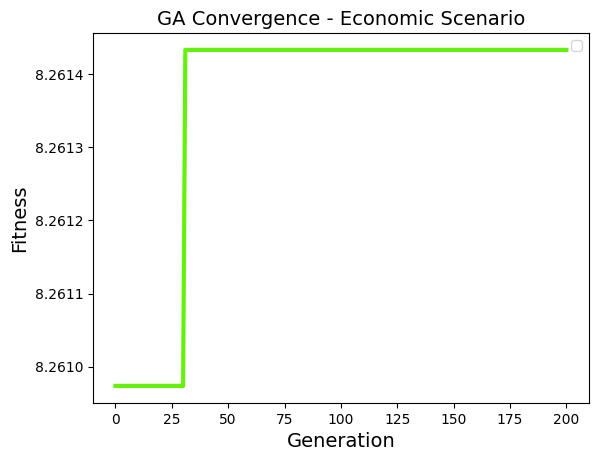

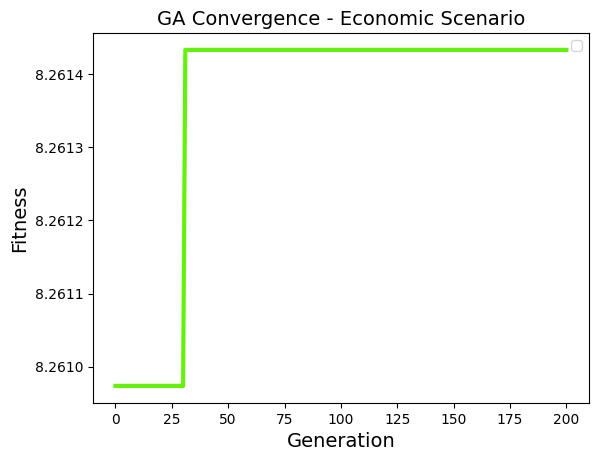

In [4]:
import numpy as np
import pandas as pd
import pygad
import chardet

# ========== 1. 数据读取 ==========
def read_csv_auto_encoding(filepath):
    with open(filepath, 'rb') as f:
        result = chardet.detect(f.read())
    return pd.read_csv(filepath, encoding=result['encoding'], index_col=0)

area_df = pd.read_excel('outputs/组团土地类型面积统计_统一英文名.xlsx', index_col=0)
planning_w = read_csv_auto_encoding('outputs/planning_weights.csv').squeeze("columns")  # Series
region_w = read_csv_auto_encoding('outputs/region_weights.csv')
scenario_w = read_csv_auto_encoding('outputs/scenario_weights.csv')
total_area_df = pd.read_excel('outputs/组团区域总面积统计.xlsx', index_col=0)

# 区域名称
# ✅ 只保留五个组团区域（不含总区）
valid_regions = ['Airport New City', 'Fengdong New City', 'Fengxi New City', 'Jinghe New City', 'Qinhan New City']
area_df = area_df.loc[valid_regions]
regions = valid_regions

land_types = area_df.columns.tolist()

# 总面积（用于惩罚项）
total_origin = total_area_df["total_area_km2"].sum()

# ========== 2. 遗传算法参数 ==========
scale_factor = 1e6
penaltyCoeff = 1
num_regions, num_lands = area_df.shape
num_genes = num_regions * num_lands

# 范围设定 ±10%
lower_bounds = area_df.values * 0.9
upper_bounds = area_df.values * 1.1
gene_space = [{'low': lower_bounds[i, j], 'high': upper_bounds[i, j]} for i in range(num_regions) for j in range(num_lands)]


# ✅ 定义经济目标层地类
economic_lands = ['Commercial land', 'Industrial land']

# ✅ 重写适应度函数：使用规划权重最大化经济目标层得分
def fitness_economic(ga_instance, solution, solution_idx):
    M = solution.reshape((num_regions, num_lands))
    total_M = M.sum()
    penalty = penaltyCoeff * ((total_M - total_origin) / total_origin) ** 2

    S_j_dict = {}
    for land in economic_lands:
        if land not in land_types or land not in region_w.index or land not in planning_w.index:
            continue
        j = land_types.index(land)
        S_ij_list = []

        for i in range(num_regions):
            row_sum = M[i, :].sum()
            A_ij = M[i, j] / row_sum if row_sum > 1e-9 else 0
            C_ij = region_w.at[land, regions[i]]
            Wj = planning_w[land]
            S_ij = A_ij * scale_factor * C_ij * Wj
            S_ij_list.append(S_ij)

        S_j = np.mean(S_ij_list) if S_ij_list else 0
        S_j_dict[land] = S_j

    T_economic_total = np.mean(list(S_j_dict.values())) if S_j_dict else 0.0
    return T_economic_total - penalty

# ✅ 初始化 GA（优化经济目标层）
ga_instance = pygad.GA(
    num_generations=200,
    num_parents_mating=50,
    fitness_func=fitness_economic,  # ✅ 使用经济目标函数
    sol_per_pop=100,
    num_genes=num_genes,
    gene_space=gene_space,
    mutation_percent_genes=10,
    parent_selection_type="rank",
    keep_parents=2,
    mutation_type="random",
    crossover_type="single_point"
)

# ✅ 执行优化
ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("✅ Best Fitness (Economic Scenario):", solution_fitness)

# ✅ 保存最优解（经济情景）
optimized_area = solution.reshape((num_regions, num_lands))
optimized_df = pd.DataFrame(optimized_area, index=regions, columns=land_types)
optimized_df.to_excel("outputs/optimized_area_economic.xlsx", index=True)
print("Optimized Area Matrix (Economic Scenario):")
print(optimized_df)

# ✅ 可视化收敛曲线
ga_instance.plot_fitness(title="GA Convergence - Economic Scenario")


In [5]:
import pandas as pd
import numpy as np

# ================== 1. 数据读取 ==================
area_df = pd.read_excel('outputs/optimized_area_economic.xlsx', index_col=0)
region_w = pd.read_csv('outputs/region_weights.csv', index_col=0)

total_area = pd.read_excel('outputs/组团区域总面积统计.xlsx', index_col=0)
total_area = total_area[total_area.index.notna()]
area_df = area_df.loc[area_df.index.intersection(total_area.index)]
scenario_w = read_csv_auto_encoding('outputs/scenario_weights.csv')
planning_w = pd.read_csv('outputs/planning_weights.csv', index_col=0).squeeze("columns")
land_types = list(area_df.columns)
eco_list = [land for land in land_types if land != "Basic land"]

# === 2. 统一区域索引（去除 total_area 中的 NaN）===
total_area = total_area[total_area.index.notna()]
area_df = area_df.loc[area_df.index.intersection(total_area.index)]

# ================== 2. 计算面积比例 A_ij ==================
region_total_area = total_area["total_area_km2"]
Aij_ratio = area_df.div(region_total_area, axis=0)

# ================== 3. 计算 S_ij,a 和 S_j,a ==================
Sij_df = pd.DataFrame(index=area_df.index, columns=land_types)

for land in land_types:
    if land not in region_w.index or land not in scenario_w.index:
        continue
    for region in area_df.index:
        Aij = Aij_ratio.at[region, land] if land in Aij_ratio.columns else 0
        Cij = region_w.at[land, region] if region in region_w.columns else 0
        Wj = planning_w.get(land, 0)
        Sij = Aij * 1e6 * Cij * Wj
        Sij_df.at[region, land] = Sij

Sij_df = Sij_df.astype(float)

# ✅ 【关键逻辑】总区域 S_j,a = 5 个区域 S_ij,a 的均值
Sij_df.loc["Xixian New Area"] = Sij_df.loc[
    ["Airport New City", "Fengdong New City", "Fengxi New City", "Jinghe New City", "Qinhan New City"]
].mean()

# ================== 4. 三大目标层计算 ==================
economic_lands = ['Commercial land', 'Industrial land']
social_lands = ['Educational land', 'Government land', 'Medical land', 'Cultural land',
                'Public facility land', 'Social welfare land', 'Residential land',
                'Sports land', 'Transportation station land', 'Historical site protection area']
ecological_lands = ['Agricultural land', 'Agricultural and forestry land', 'Basic green land',
                    'Park green land', 'Water area', 'Basic land']

T_df = pd.DataFrame(index=Sij_df.index)
T_df['Economic'] = Sij_df[economic_lands].mean(axis=1)
T_df['Social'] = Sij_df[social_lands].mean(axis=1)
T_df['Ecological'] = Sij_df[ecological_lands].mean(axis=1)
T_df['T_Total'] = T_df['Economic'] + T_df['Social'] + T_df['Ecological']

# ================== 5. 耦合协调度模型 D ==================
n = 3
K = 80
xixian_Tk = T_df.loc["Xixian New Area", ['Economic', 'Social', 'Ecological']]
C = (n * (xixian_Tk.prod())**(1/n)) / xixian_Tk.sum()
T_norm = xixian_Tk.sum() / K
D = np.sqrt(C * T_norm)

T_df.loc["Xixian New Area", "C"] = C
T_df.loc["Xixian New Area", "T_norm"] = T_norm
T_df.loc["Xixian New Area", "D"] = D

# ================== 6. 输出结果 ==================
Sij_output = 'outputs/06_规划指标层得分_经济_区域x规划权重.xlsx'
T_output = 'outputs/06_规划目标层得分_区域总得分_耦合模型_经济_区域x规划权重.xlsx'

Sij_df.to_excel(Sij_output)
T_df.to_excel(T_output)

print("✅ 经济规划得分与耦合模型计算完成！")
print(f"输出文件：\n- 指标层得分：{Sij_output}\n- 目标层与D值：{T_output}")
print("\n【Xixian New Area】耦合协调模型结果：")
print("T-values:", xixian_Tk.to_dict())
print(f"C = {C:.6f}, T_norm = {T_norm:.6f}, D = {D:.6f}")

✅ 经济规划得分与耦合模型计算完成！
输出文件：
- 指标层得分：outputs/06_规划指标层得分_经济_区域x规划权重.xlsx
- 目标层与D值：outputs/06_规划目标层得分_区域总得分_耦合模型_经济_区域x规划权重.xlsx

【Xixian New Area】耦合协调模型结果：
T-values: {'Economic': 9.214935602145868, 'Social': 5.671244429334891, 'Ecological': 29.69081138718792}
C = 0.779127, T_norm = 0.557212, D = 0.658892


In [6]:
import pandas as pd
import numpy as np

# ================== 1. 数据读取 ==================
area_df = pd.read_excel('outputs/optimized_area_economic.xlsx', index_col=0)
region_w = pd.read_csv('outputs/region_weights.csv', index_col=0)

total_area = pd.read_excel('outputs/组团区域总面积统计.xlsx', index_col=0)
total_area = total_area[total_area.index.notna()]
area_df = area_df.loc[area_df.index.intersection(total_area.index)]
scenario_w = read_csv_auto_encoding('outputs/scenario_weights.csv')
planning_w = pd.read_csv('outputs/planning_weights.csv', index_col=0).squeeze("columns")
land_types = list(area_df.columns)
eco_list = [land for land in land_types if land != "Basic land"]

# === 2. 统一区域索引（去除 total_area 中的 NaN）===
total_area = total_area[total_area.index.notna()]
area_df = area_df.loc[area_df.index.intersection(total_area.index)]

# ================== 2. 计算面积比例 A_ij ==================
region_total_area = total_area["total_area_km2"]
Aij_ratio = area_df.div(region_total_area, axis=0)

# ================== 3. 计算 S_ij,a 和 S_j,a ==================
Sij_df = pd.DataFrame(index=area_df.index, columns=land_types)

for land in land_types:
    if land not in region_w.index or land not in scenario_w.index:
        continue
    for region in area_df.index:
        Aij = Aij_ratio.at[region, land] if land in Aij_ratio.columns else 0
        Cij = region_w.at[land, region] if region in region_w.columns else 0
        N_aj = scenario_w.at[land, 'Economic Scenario Weight']
        Sij = Aij * 1e6 * Cij * N_aj * 5
        Sij_df.at[region, land] = Sij

Sij_df = Sij_df.astype(float)

# ✅ 【关键逻辑】总区域 S_j,a = 5 个区域 S_ij,a 的均值
Sij_df.loc["Xixian New Area"] = Sij_df.loc[
    ["Airport New City", "Fengdong New City", "Fengxi New City", "Jinghe New City", "Qinhan New City"]
].mean()

# ================== 4. 三大目标层计算 ==================
economic_lands = ['Commercial land', 'Industrial land']
social_lands = ['Educational land', 'Government land', 'Medical land', 'Cultural land',
                'Public facility land', 'Social welfare land', 'Residential land',
                'Sports land', 'Transportation station land', 'Historical site protection area']
ecological_lands = ['Agricultural land', 'Agricultural and forestry land', 'Basic green land',
                    'Park green land', 'Water area', 'Basic land']

T_df = pd.DataFrame(index=Sij_df.index)
T_df['Economic'] = Sij_df[economic_lands].mean(axis=1)
T_df['Social'] = Sij_df[social_lands].mean(axis=1)
T_df['Ecological'] = Sij_df[ecological_lands].mean(axis=1)
T_df['T_Total'] = T_df['Economic'] + T_df['Social'] + T_df['Ecological']

# ================== 5. 耦合协调度模型 D ==================
n = 3
K = 80
xixian_Tk = T_df.loc["Xixian New Area", ['Economic', 'Social', 'Ecological']]
C = (n * (xixian_Tk.prod())**(1/n)) / xixian_Tk.sum()
T_norm = xixian_Tk.sum() / K
D = np.sqrt(C * T_norm)

T_df.loc["Xixian New Area", "C"] = C
T_df.loc["Xixian New Area", "T_norm"] = T_norm
T_df.loc["Xixian New Area", "D"] = D

# ================== 6. 输出结果 ==================
Sij_output = 'outputs/06_需求指标层得分_经济情景_区域x情景权重.xlsx'
T_output = 'outputs/06_需求目标层得分_区域总得分_耦合模型_经济情景_区域x情景权重.xlsx'

Sij_df.to_excel(Sij_output)
T_df.to_excel(T_output)

print("✅ 经济规划得分与耦合模型计算完成！")
print(f"输出文件：\n- 指标层得分：{Sij_output}\n- 目标层与D值：{T_output}")
print("\n【Xixian New Area】耦合协调模型结果：")
print("T-values:", xixian_Tk.to_dict())
print(f"C = {C:.6f}, T_norm = {T_norm:.6f}, D = {D:.6f}")

✅ 经济规划得分与耦合模型计算完成！
输出文件：
- 指标层得分：outputs/06_需求指标层得分_经济情景_区域x情景权重.xlsx
- 目标层与D值：outputs/06_需求目标层得分_区域总得分_耦合模型_经济情景_区域x情景权重.xlsx

【Xixian New Area】耦合协调模型结果：
T-values: {'Economic': 11.147423989286835, 'Social': 5.299343844412015, 'Ecological': 47.71354964136674}
C = 0.660492, T_norm = 0.802004, D = 0.727817
